# Throughput

## Import Data

In [1]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
data_frames = []

for file in glob.glob("*_1.orunchrt.summary.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pd.json_normalize(data)
        df['variant'] = file.replace("_1.orunchrt.summary.bench","")
        df['name'] = df['name'].apply(lambda x : x.replace(".orunchrt", ""))
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
52,LU_decomposition.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,32.845553,32.781148,0.064002,136412,68784.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17205031235,163,16777701,65633,2,0,16814346,16814346,0.873586,4.12.0+domains+effects
52,LU_decomposition.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,33.024070,32.951572,0.071999,136416,68443.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17205031234,162,16777700,65633,2,0,16814346,16814346,0.873610,4.12.0+domains
13,LU_decomposition_multicore.12_2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,3.700510,43.645723,0.265739,129336,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17226633628,3135520,19915778,84272,1274,0,12922603,12979185,5.824594,4.12.0+domains
13,LU_decomposition_multicore.12_2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,3.726693,43.881073,0.328757,128940,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17226535613,3129468,19909746,84330,1278,0,12964071,12966897,5.545341,4.12.0+domains+effects
8,LU_decomposition_multicore.16_2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.912111,45.101666,0.620959,137096,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17241926869,4180013,20961287,90068,1149,0,8878038,13090793,6.280064,4.12.0+domains+effects
8,LU_decomposition_multicore.16_2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.929766,45.099742,0.845242,136460,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17244310344,4159869,20941161,89488,1150,0,8733916,13086697,6.222030,4.12.0+domains
55,LU_decomposition_multicore.1_2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,33.240513,33.184099,0.056000,103572,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17205053180,9841,16787379,65690,58,0,12628231,12628231,1.061864,4.12.0+domains+effects
55,LU_decomposition_multicore.1_2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,33.291435,33.222895,0.068005,103624,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17205053179,9840,16787378,65690,58,0,12628231,12628231,1.061888,4.12.0+domains
16,LU_decomposition_multicore.20_2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.547551,48.531897,1.108290,147020,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17265437771,5179649,21961915,92558,971,0,4751045,13210593,7.823150,4.12.0+domains+effects
16,LU_decomposition_multicore.20_2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.556809,48.906571,0.851348,147696,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,17268567017,5084282,21866534,89579,935,0,13287369,13210593,8.546510,4.12.0+domains


## Prepare multicore data

Filter rows whose names have multicore in them. 

In [3]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
mdf.sort_values(['name','variant','num_domains'])

<ipython-input-3-0147373d3a46>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-3-0147373d3a46>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
<ipython-input-3-0147373d3a46>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,num_domains,ntime_secs,btime_secs
55,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,33.291435,33.222895,0.068005,103624,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,65690,58,0,12628231,12628231,1.061888,4.12.0+domains,1,0.986607,32
91,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,17.196069,34.306990,0.075997,106180,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,73453,3821,0,12657157,12657157,1.736411,4.12.0+domains,2,1.910062,32
3,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,8.781214,34.944104,0.124028,110616,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,78065,2951,0,12694529,12715009,2.588081,4.12.0+domains,4,3.740434,32
54,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,4.708244,37.245906,0.184306,119896,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,81185,1801,0,12756985,12830713,4.140833,4.12.0+domains,8,6.976179,32
13,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,3.700510,43.645723,0.265739,129336,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,84272,1274,0,12922603,12979185,5.824594,4.12.0+domains,12,8.875953,32
8,LU_decomposition_multicore.2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.929766,45.099742,0.845242,136460,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,89488,1150,0,8733916,13086697,6.222030,4.12.0+domains,16,11.210982,32
16,LU_decomposition_multicore.2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.556809,48.906571,0.851348,147696,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,89579,935,0,13287369,13210593,8.546510,4.12.0+domains,20,12.846307,32
30,LU_decomposition_multicore.2048,"chrt -r 1 taskset --cpu-list 2-13,16-27 ./LU_d...",2.492424,55.551522,1.024268,155528,102681.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,91243,827,0,823994,13326297,99.792004,4.12.0+domains,24,13.178156,32
55,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,33.240513,33.184099,0.056000,103572,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,65690,58,0,12628231,12628231,1.061864,4.12.0+domains+effects,1,0.988118,32
91,LU_decomposition_multicore.2048,chrt -r 1 taskset --cpu-list 2-13 ./LU_decompo...,17.132435,34.163614,0.091998,106168,103022.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+multicore,gcc,...,73809,4009,0,12657157,12657157,1.737303,4.12.0+domains+effects,2,1.917156,32


# Time

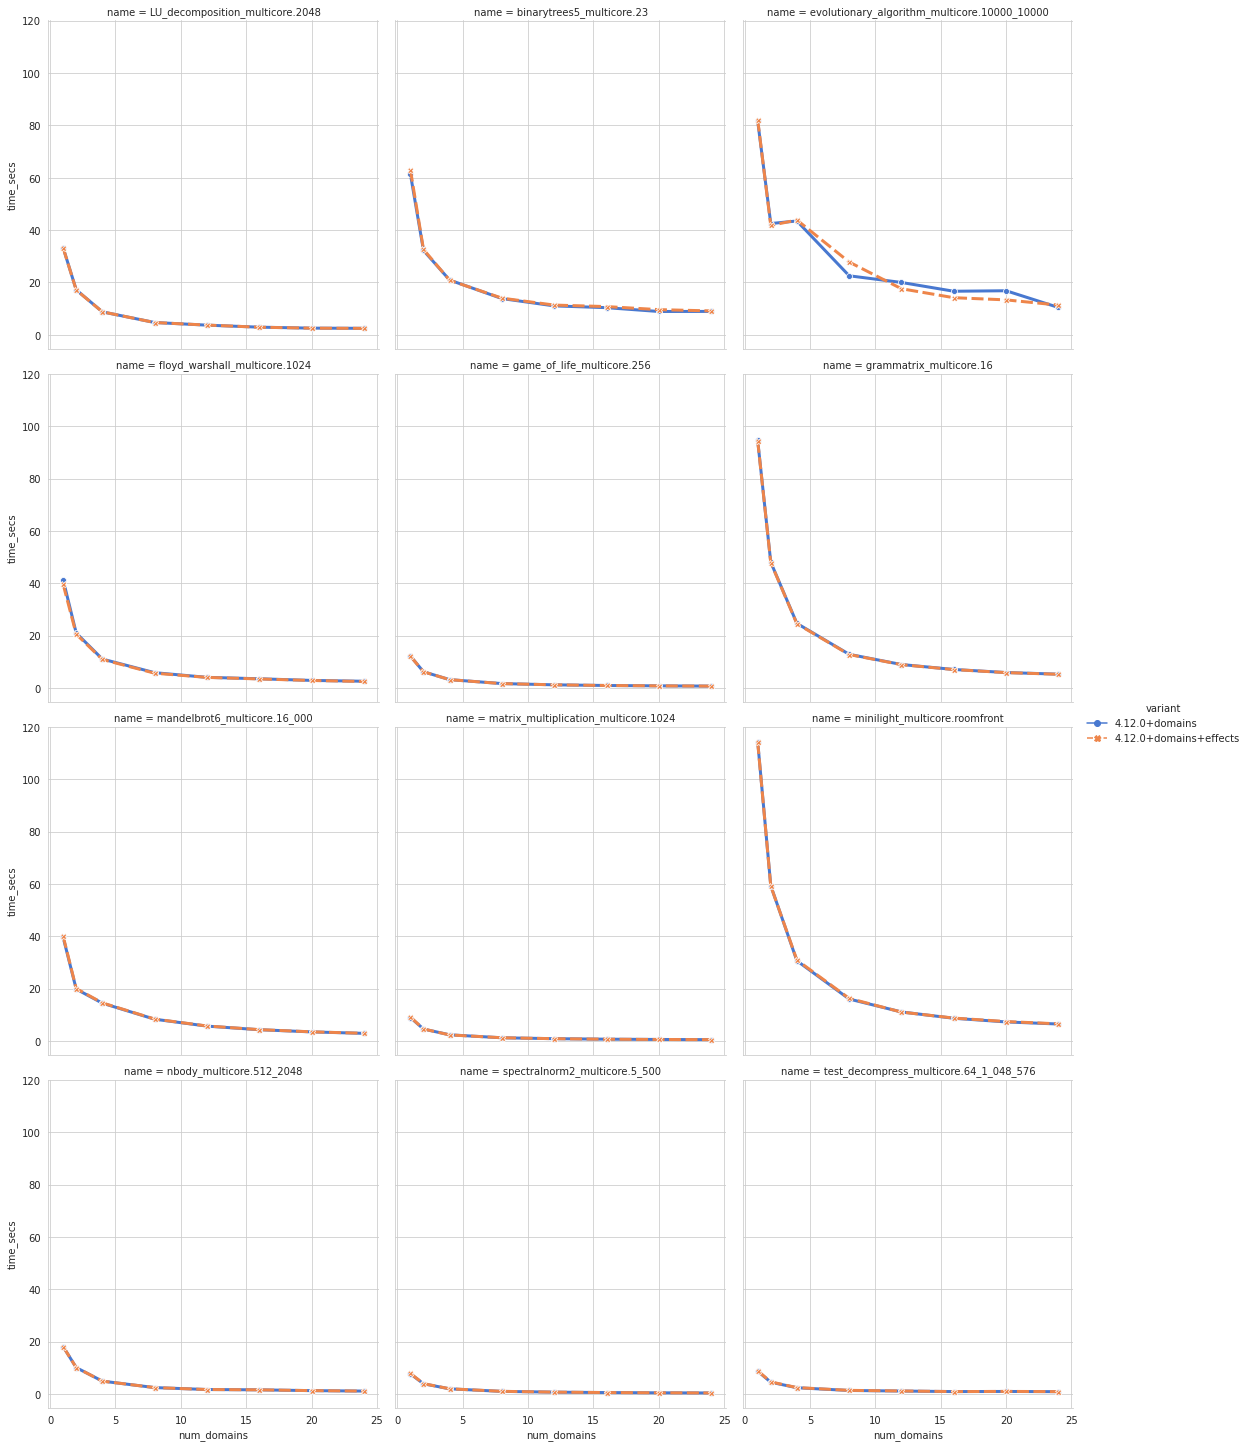

In [4]:
mdf = mdf.sort_values(['name'])
sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

## Speedup

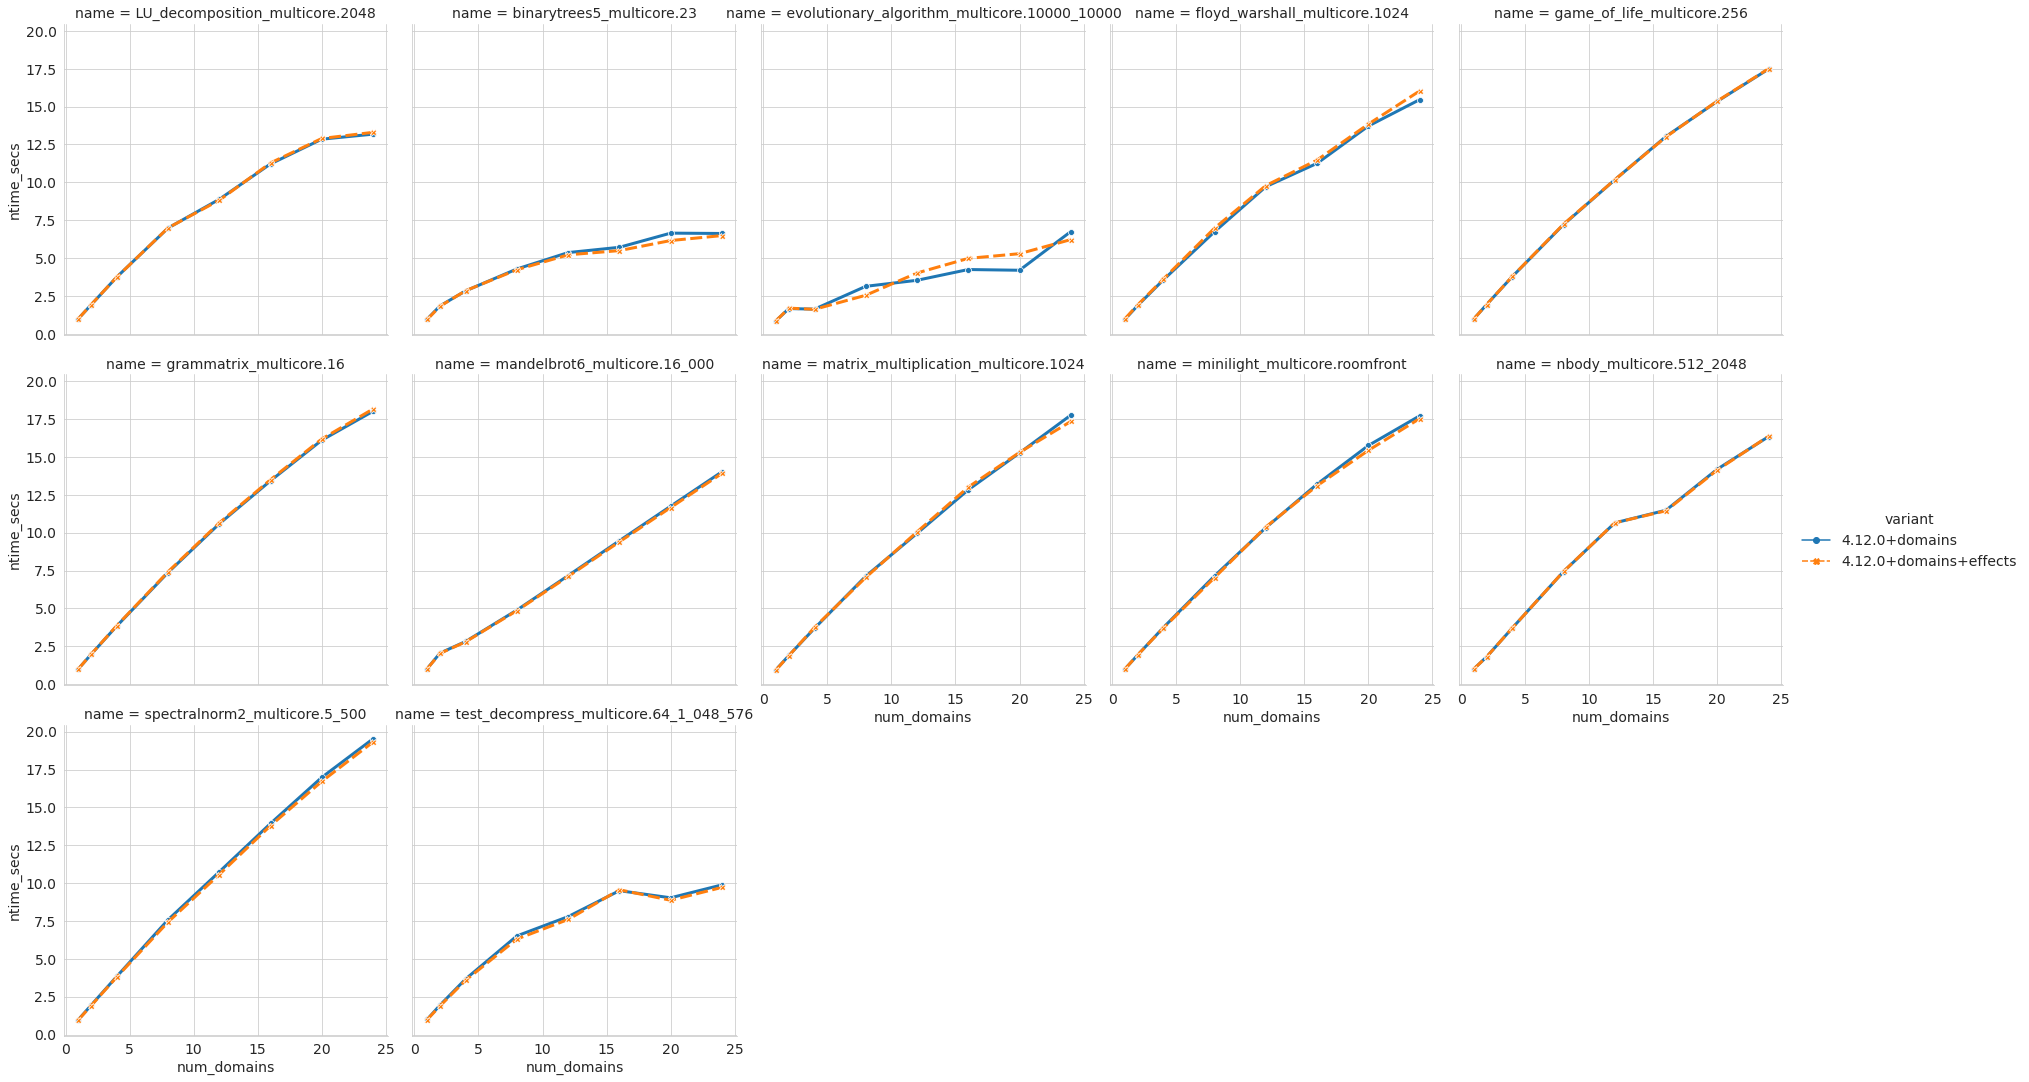

In [5]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 5, 
                lw=3)


# Latency

In [3]:
data_frames = []

for file in glob.glob("*_1.pausetimes_multicore.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = file.replace("_1.pausetimes_multicore.bench","")
        data_frames.append(df)

df2 = pd.concat(data_frames, sort=False)

mdf2 = df2.loc[df2['name'].str.contains('.*multicore.*',regex=True),:]
mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
mdf2['name'] = mdf2['name'].replace('\..*?_','.',regex=True)

latency_df = pd.DataFrame.copy(mdf2)
mdf2.sort_values(["name"])

<ipython-input-3-0dbaba47b18e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-3-0dbaba47b18e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
<ipython-input-3-0dbaba47b18e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,name,mean_latency,max_latency,distr_latency,variant,num_domains
29,LU_decomposition_multicore.2048,30177203,246864694,"[154, 186, 209, 263, 7607080, 26910537, 474630...",4.12.0+domains+effects+instrumented,12
81,LU_decomposition_multicore.2048,21871161,135472387,"[153, 185, 209, 399, 7480585, 23385161, 354700...",4.12.0+domains+effects+instrumented,8
76,LU_decomposition_multicore.2048,44802479,425669612,"[151, 184, 206, 241, 7629824, 31489600, 658572...",4.12.0+domains+effects+instrumented,20
101,LU_decomposition_multicore.2048,13015976,102796535,"[141, 166, 200, 264919, 1940030, 8935854, 1975...",4.12.0+domains+effects+instrumented,4
88,LU_decomposition_multicore.2048,1611,1706511,"[143, 143, 144, 145, 2697, 2890, 2953, 3013, 3...",4.12.0+domains+effects+instrumented,1
...,...,...,...,...,...,...
14,test_decompress_multicore.64_1_048_576,22983,417096,"[155, 160, 177, 14481, 21081, 32001, 39505, 41...",4.12.0+domains+effects+instrumented,1
52,test_decompress_multicore.64_1_048_576,45874028,253370721,"[162, 189, 211, 282, 41254432, 65208525, 69192...",4.12.0+domains+effects+instrumented,16
54,test_decompress_multicore.64_1_048_576,3968748,39450146,"[138, 151, 180, 119944, 141682, 797473, 996734...",4.12.0+domains+effects+instrumented,2
1,test_decompress_multicore.64_1_048_576,52332738,261212938,"[153, 187, 212, 324, 27146380, 69156166, 85157...",4.12.0+domains+effects+instrumented,20


## Max latency

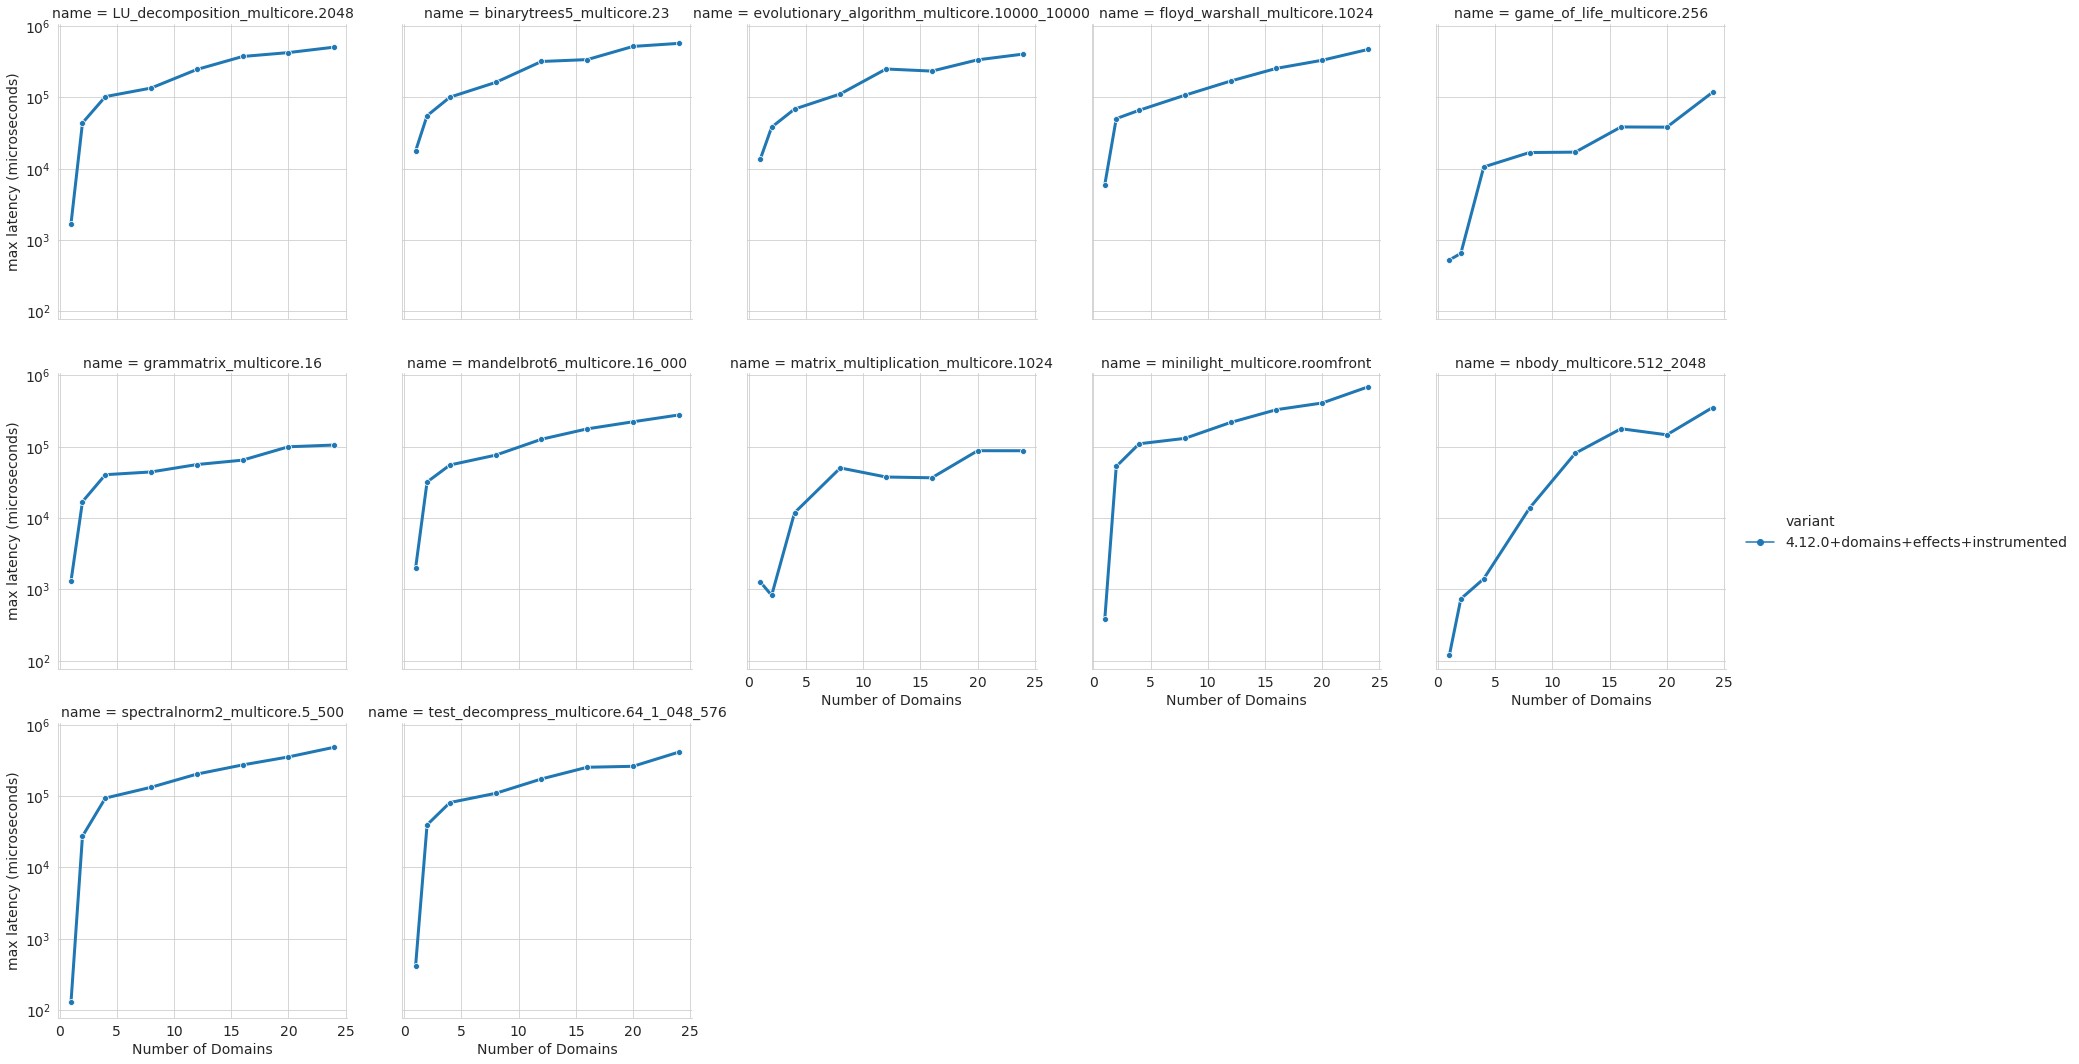

In [4]:
def plotLatencyAt(df,at):
    fdf = df.filter(["name","variant",at + "_latency","num_domains"])
    fdf.sort_values(by="name",inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                                  "legend.fontsize":14}):
        g = sns.relplot(x='num_domains', y = at + '_latency', hue='variant', col='name',
                        data=fdf, kind='line', style='variant', markers=True, col_wrap = 5, lw=3)
        for ax in g.axes:
            ax.set_ylabel(at + " latency (microseconds)")
            ax.set_xlabel("Number of Domains")
            ax.set_yscale('log')
        
plotLatencyAt(mdf2,"max")

## 99.9th percentile latency

/usr/lib/python3/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


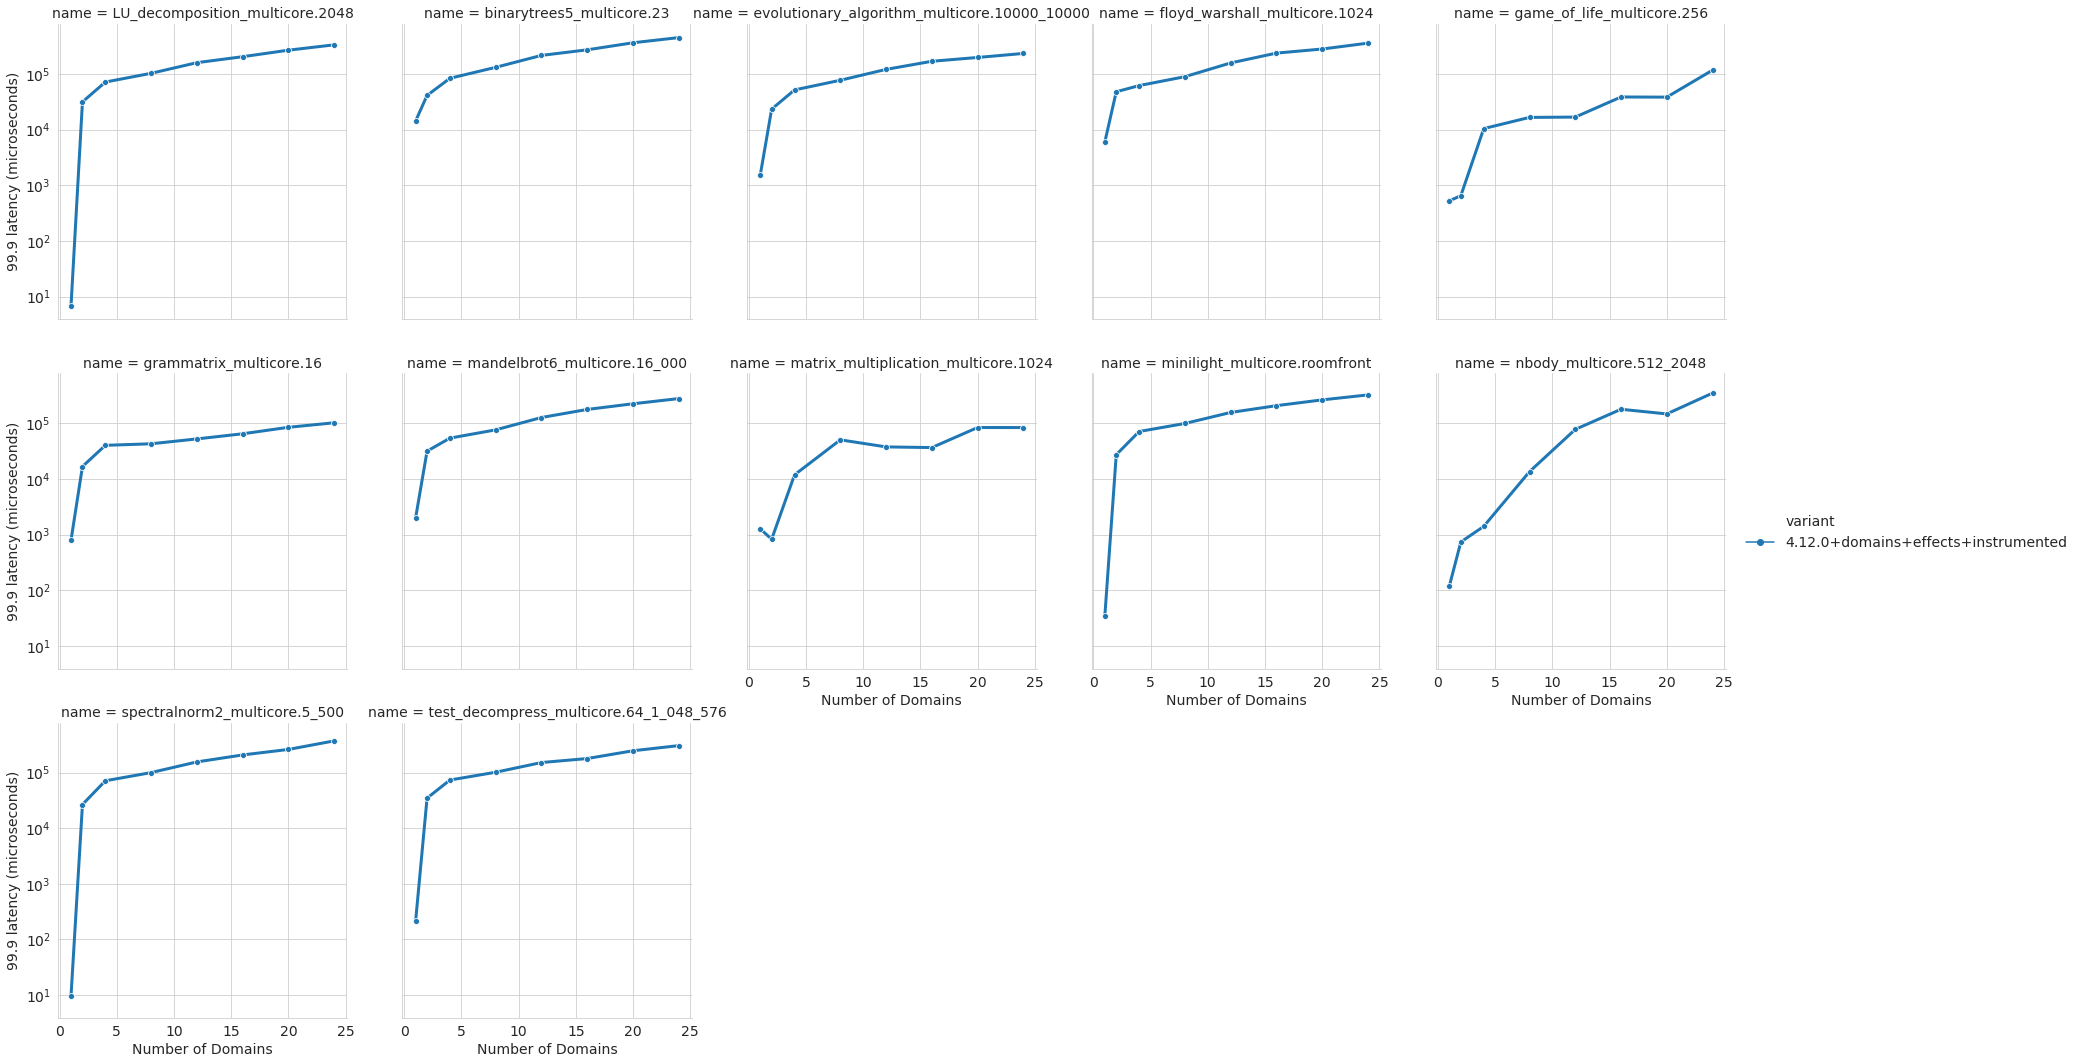

In [5]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

mdf2 = getLatencyAt(mdf2,"99.9",-1)
plotLatencyAt(mdf2,"99.9")

## 99th percentile latency

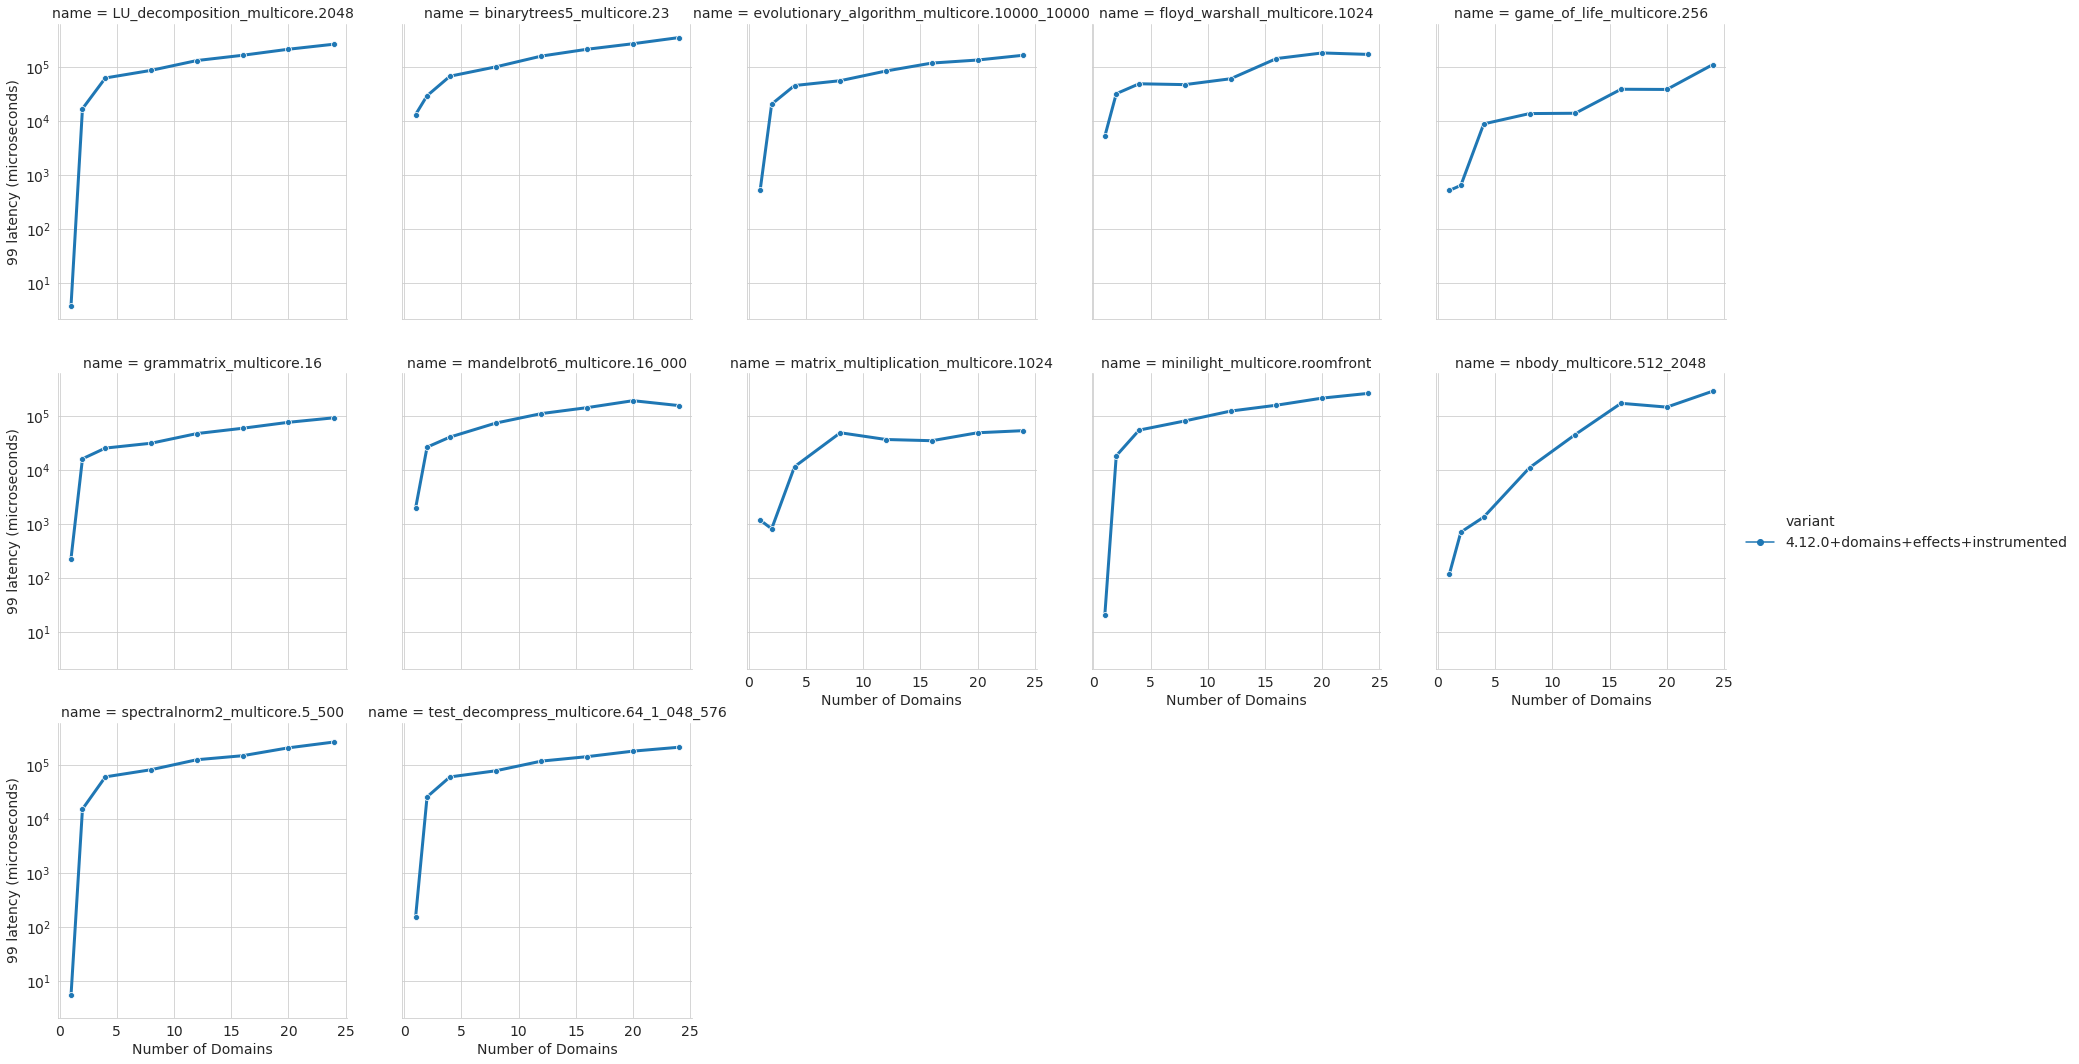

In [6]:
mdf2 = getLatencyAt(mdf2,"99",-2)
plotLatencyAt(mdf2,"99")

## Mean latency

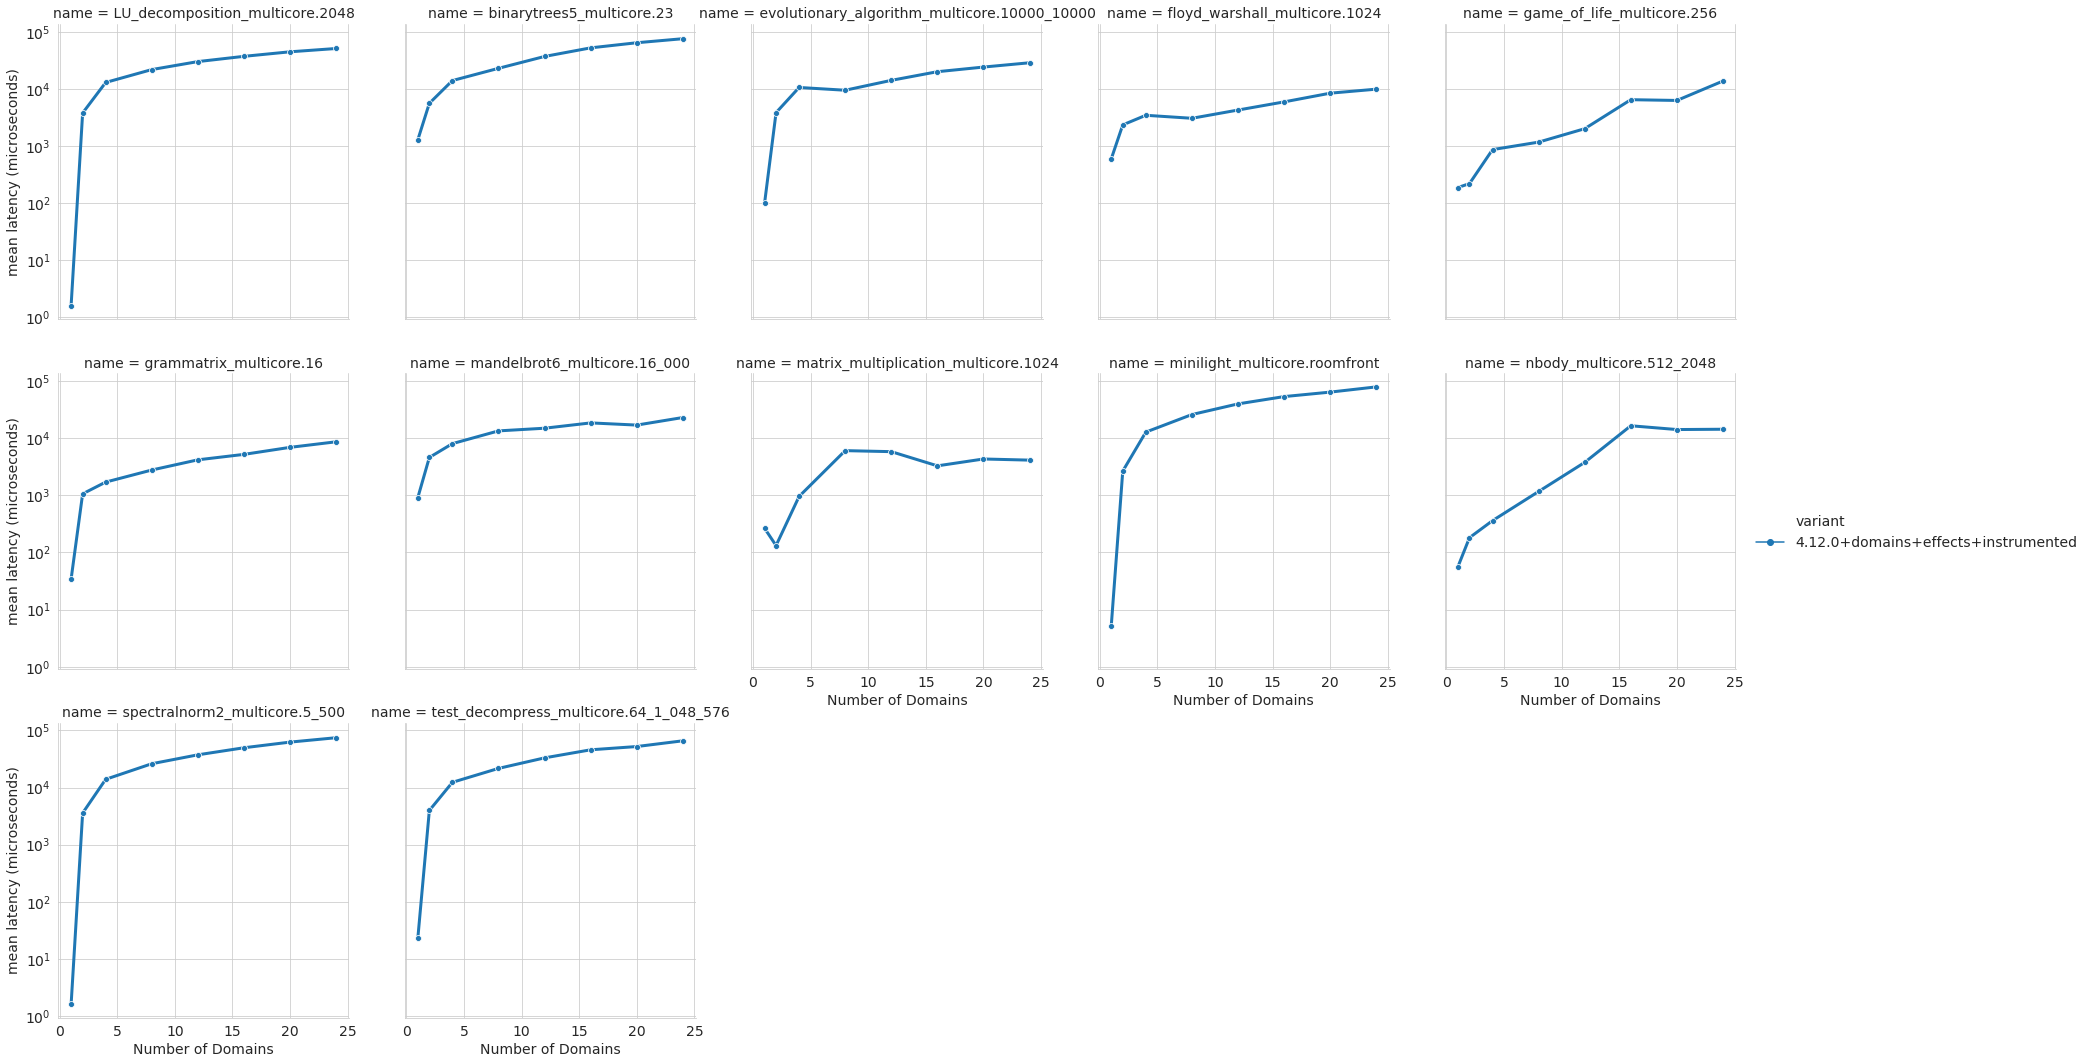

In [7]:
plotLatencyAt(mdf2,"mean")